In [80]:
%pylab inline
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


First we read images and the light angles in the format of
$$(\phi,\theta)$$

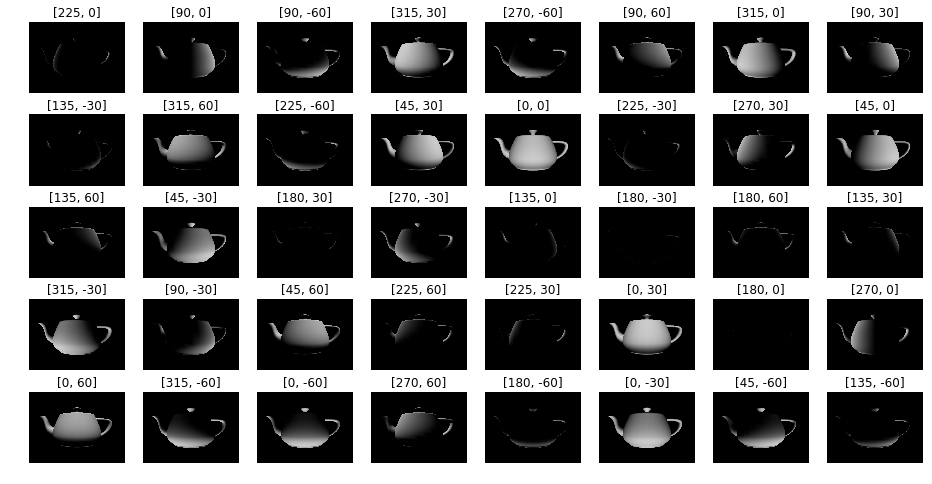

In [81]:
import os, re

teapots = []
light_angles = []

for file_name in os.listdir("data"):
    match = re.match(r'teapot_([\-0-9]*)_([\-0-9]*)\.png', file_name)
    teapots.append(imread("data/" + file_name))
    light_angles.append([int(match.group(1)), int(match.group(2))])

def display_teapots(teapots_to_diplay, labels=[]):
    figure(figsize=(16,8))
    for idx, teapot in enumerate(teapots_to_diplay):
        subplot(5,len(teapots)/5,idx+1)
        axis('off')
        if labels:
            title(labels[idx])
        imshow(clip(teapot,0,1))

display_teapots(teapots, light_angles)

Now we obtain the unit vectors corresponding to lights, using the equation

$$(D_x, D_y, D_z) = (\sin(\phi)*\sin(\theta),\cos(\phi),-\sin(\phi)*\cos(\theta))$$  

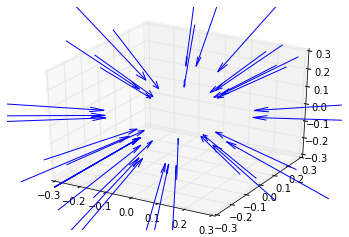

In [82]:
phis = array(light_angles)[:,0]
thetas = array(light_angles)[:,1]
D = squeeze(dstack((sin(phis) * sin(thetas), cos(phis), -sin(phis)*cos(thetas))))

fig = figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(-.25*D[:,0], -.25*D[:,1], -.25*D[:,2], D[:,0],D[:,1],D[:,2], length=.5, arrow_length_ratio=.1)

Now we import the HDR probe.

(1000, 1000, 3)


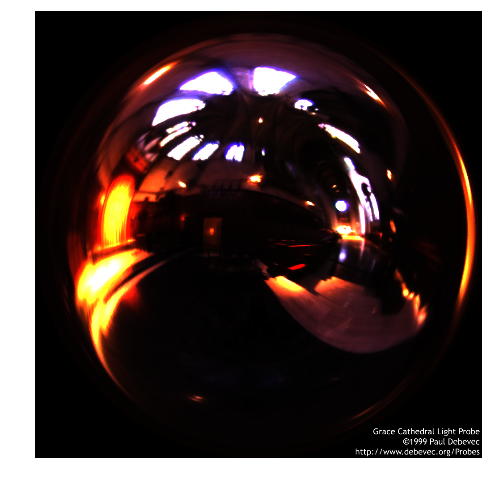

In [83]:
import imageio
probe_image = imageio.imread('grace_probe.hdr')
print probe_image.shape
figure(figsize=(8,8))
axis('off')
imshow(clip(probe_image,0,1))

-------
For a given unit vector $(D_x, D_y, D_z)$ we map the UV coordinates of the light probe image as $(D_xr, D_yr)$, where

$$ r = \frac{\arccos(D_z)}{\pi \sqrt{D_x^2+D_y^2}}$$

We first compute all the light's colors

In [84]:
import math

def colors_from_sphere(probe_image, D):
    light_colors = []
    for d in D:
        r = arccos(d[2])/(math.pi*sqrt(d[0]**2 + d[1]**2))
        UV = array([d[0]*r, d[1]*r])
        # convert to image_space
        UV = (UV + [1,1])*0.5*probe_image.shape[:2]
        light_colors.append(probe_image[UV[0]][UV[1]])
    return array(light_colors)

light_colors = colors_from_sphere(probe_image, D)

/home/kyp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Next we apply the image-based lighting to each of the images

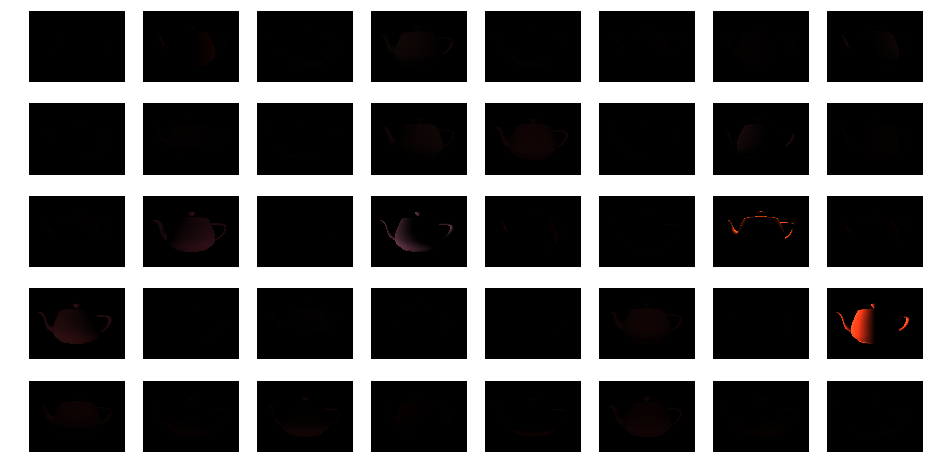

In [85]:
def light_teapots(teapots, light_colors):
    return [teapot[:,:,:1]*light_colors[idx] for idx, teapot in enumerate(teapots)]

display_teapots(light_teapots(teapots, light_colors))

Finally, we add all the images to get the final result.

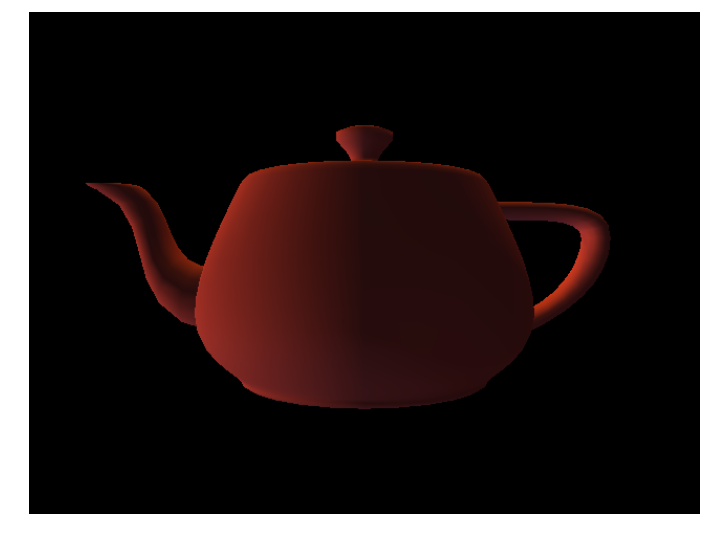

In [86]:
final_teapot = sum(array(lighted_teapots), axis=0)

figure(figsize=(12,12))
axis('off')
imshow(final_teapot/4)

And we try it with the rest of the probes

/home/kyp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


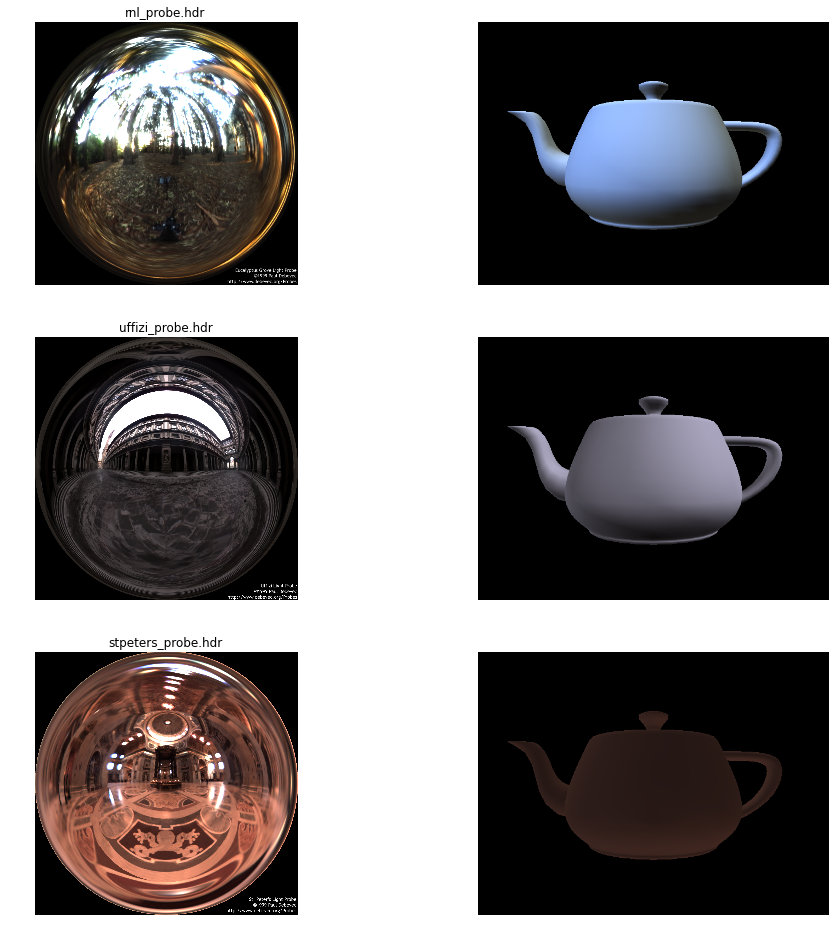

In [92]:
probes_files = [
    "rnl_probe.hdr",
    "uffizi_probe.hdr",
    "stpeters_probe.hdr"
]
intensities = [25, 25, 15]

figure(figsize=(16,16))
for idx, file in enumerate(probes_files):
    probe_image = imageio.imread(file)    
    subplot(len(probes_files), 2, 2*idx+1)
    title(file)
    axis('off')
    imshow(clip(probe_image,0,1))
    subplot(len(probes_files),2 , 2*idx+2)
    teapot = sum(array(light_teapots(teapots, colors_from_sphere(probe_image,D))), axis=0)
    axis('off')
    imshow(clip(teapot/intensities[idx], 0, 1))
    